## A Fast.ai protein classifier using images
##### following: https://github.com/fastai/fastai/blob/main/nbs/10_tutorial.pets.ipynb

In [1]:
from fastai.vision.all import *

In [32]:
from pathlib import Path

In [37]:
base_dir = Path('/mnt/raid1/dataset/shrec-2025-protein-classification/v2-20250331/train-labeled-screenshots')

In [53]:
all_classes = sorted([x.stem for x in list(base_dir.iterdir())])

In [54]:
print(f'{all_classes[:5]} ... {all_classes[-5:]}')

['00', '01', '05', '06', '08'] ... ['90', '91', '92', '94', '96']


In [55]:
num_classes = len(all_classes)

In [56]:
items = get_image_files(base_dir)
fn = items[0]; fn

Path('/mnt/raid1/dataset/shrec-2025-protein-classification/v2-20250331/train-labeled-screenshots/96/0001-96-8ugd_8:R:3U_model1-0-0.jpg')

In [57]:
print(f'Found {len(items)} images in {num_classes} classes')

Found 12147 images in 55 classes


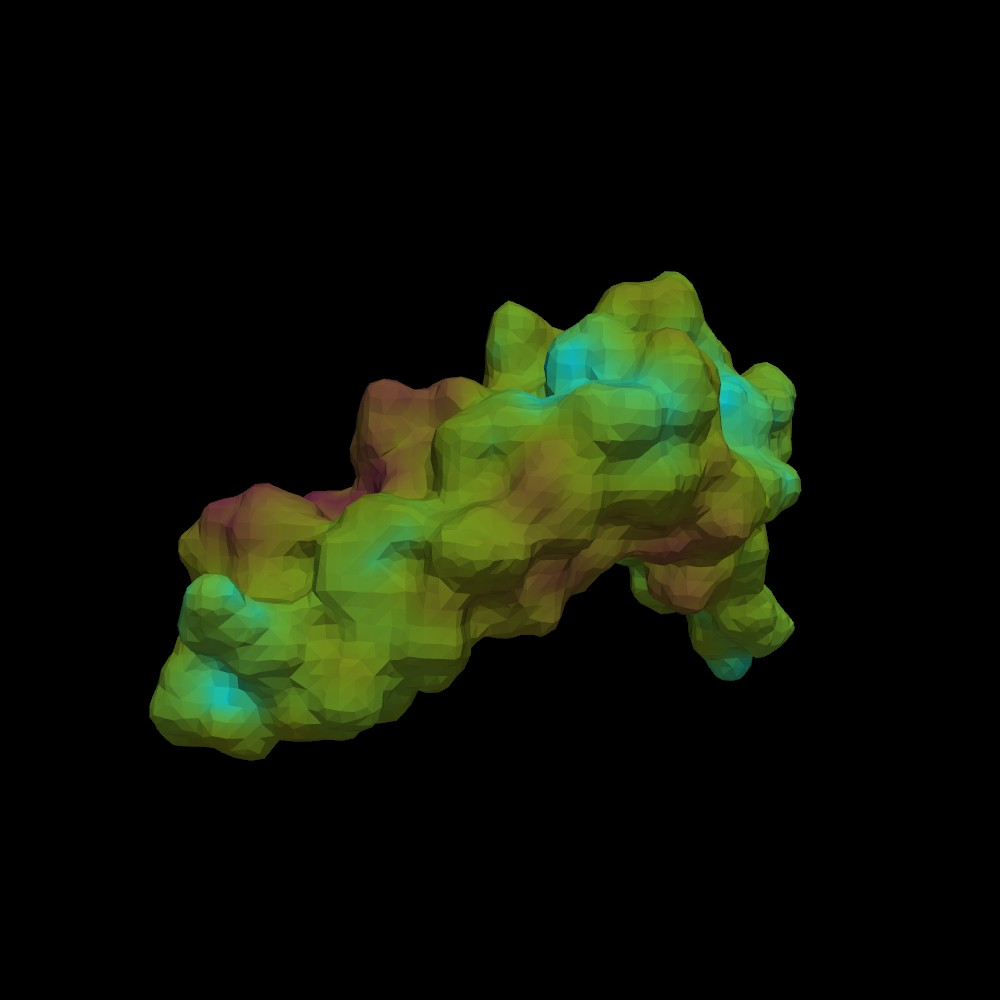

In [58]:
img = PILImage.create(fn); img

In [59]:
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 1000, 1000]), fastai.torch_core.TensorImage)

In [60]:
label = parent_label(fn); label

'96'

In [62]:
tcat = Categorize(vocab=all_classes)
lbl = tcat(lbl); lbl

TensorCategory(54)

In [63]:
decoded_label = tcat.decode(lbl)
decoded_label

'96'

In [64]:
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn)
img.shape

torch.Size([3, 1000, 1000])

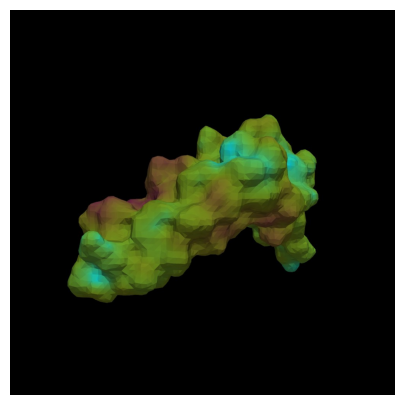

In [66]:
pipe.show(img, figsize=(5,5), cmap='Greys');

In [67]:
type(img)

fastai.torch_core.TensorImage

In [126]:
env = {}
env['img_sz'] = 320

In [69]:
def resized_image(fn:Path, sz=env['img_sz']):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

In [70]:
class TitledImage(fastuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

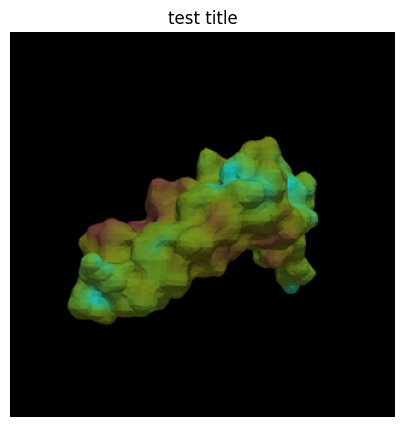

In [71]:
img = resized_image(items[0])
TitledImage(img,'test title').show()

In [184]:
labeller = using_attr(RegexLabeller(pat = r'^\d\d\d\d-(\d\d)-.*.jpg$'), 'name')
env['labeller'] = labeller

In [185]:
labeller(fn)

'96'

In [120]:
class ProteinsTfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return (resized_image(o), self.o2i[self.lblr(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [122]:
class ProteinsTfm(ItemTransform):
    def setups(self, items):
        self.labeller = env['labeller']
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [116]:
vals = list(map(labeller, items))
vocab, o2i = uniqueify(vals, sort=True, bidir=True)
tfm = ProteinsTfm(vocab, o2i, labeller)

In [117]:
len(vocab)

55

In [118]:
x,y = tfm(items[0])
x.shape,y

(torch.Size([3, 320, 320]), 54)

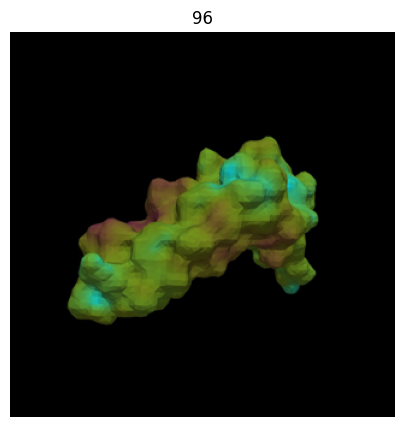

In [119]:
dec = tfm.decode([x,y])
dec.show()

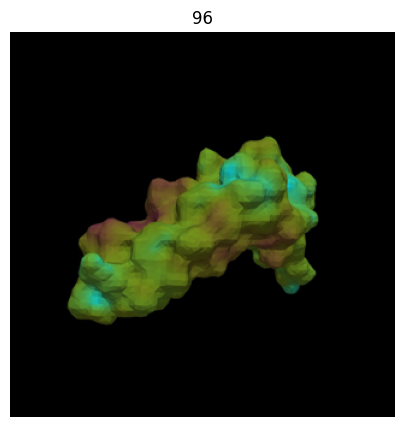

In [121]:
dec = tfm.decode(tfm(items[0]))
dec.show()

In [123]:
tfm = ProteinsTfm()
tfm.setup(items)
x,y = tfm(items[0])
x.shape, y

(torch.Size([3, 320, 320]), 54)

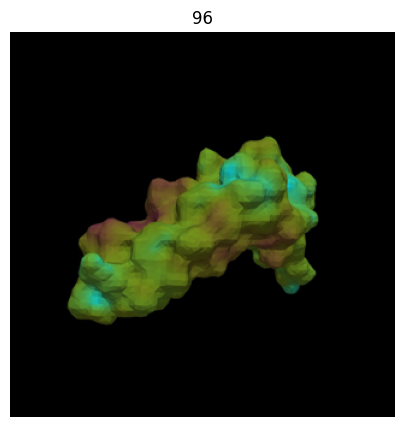

In [125]:
dec = tfm.decode((x,y))
dec.show()

In [127]:
tfms = Pipeline([ProteinsTfm(), Resize(env['img_sz']), FlipItem(p=1), ToTensor()])

In [171]:
tfms.setup(items)

In [172]:
tfms.vocab[:5]

['00', '01', '05', '06', '08']

In [130]:
x,y = tfms(items[0])
x.shape,y

(torch.Size([3, 320, 320]), 54)

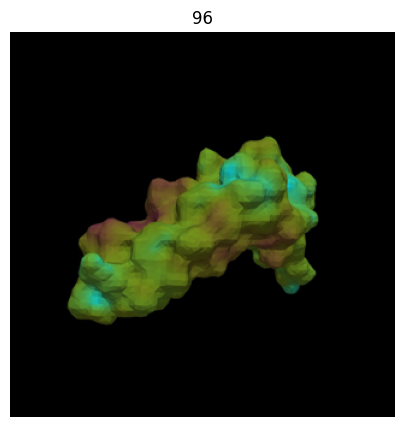

In [131]:
tfms.show(tfms(items[0]))

In [132]:
tfms

Pipeline: ProteinsTfm -> FlipItem -- {'p': 1} -> Resize -- {'size': (320, 320), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor

In [133]:
FlipItem.order,Resize.order

(0, 1)

In [222]:
class ProteinsTfm(ItemTransform):
    order = -5
    #def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def setups(self, items):
        print(f'Calling ProteinsTfm.setups()')
        self.labeller = env['labeller']
        vals = map(self.labeller, items)
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)
        #tcat = Categorize(vocab=self.vocab)
        #print(f'Calling ProteinsTfm.setups() - {tcat(self.labeller(items)[0])}')

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [223]:
vals = map(labeller, items)

In [224]:
vocab,o2i = uniqueify(vals, sort=True, bidir=True)

In [225]:
print(f'{vocab[:5]} - {o2i}')

['00', '01', '05', '06', '08'] - {'00': 0, '01': 1, '05': 2, '06': 3, '08': 4, '11': 5, '12': 6, '14': 7, '15': 8, '16': 9, '17': 10, '18': 11, '19': 12, '20': 13, '21': 14, '22': 15, '25': 16, '32': 17, '33': 18, '34': 19, '35': 20, '37': 21, '38': 22, '40': 23, '41': 24, '45': 25, '46': 26, '51': 27, '53': 28, '54': 29, '55': 30, '56': 31, '60': 32, '61': 33, '62': 34, '64': 35, '65': 36, '66': 37, '69': 38, '70': 39, '71': 40, '74': 41, '75': 42, '79': 43, '81': 44, '83': 45, '84': 46, '86': 47, '87': 48, '88': 49, '90': 50, '91': 51, '92': 52, '94': 53, '96': 54}


In [242]:
tfms = Pipeline([Resize(env['img_sz']), ProteinsTfm(), FlipItem(p=0.5), ToTensor()])
tfms

Pipeline: ProteinsTfm -> FlipItem -- {'p': 0.5} -> Resize -- {'size': (320, 320), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor

In [243]:
tls = TfmdLists(items, [Resize(env['img_sz']), ProteinsTfm(), FlipItem(p=0.5), ToTensor()])
x,y = tls[0]
x.shape,y

Calling ProteinsTfm.setups()


(torch.Size([3, 320, 320]), 54)

In [228]:
tls.vocab[:5]

['00', '01', '05', '06', '08']

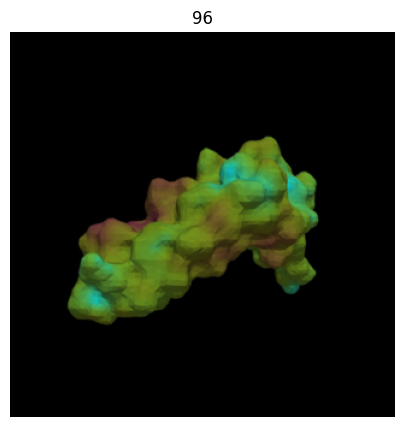

In [229]:
tls.show((x,y))

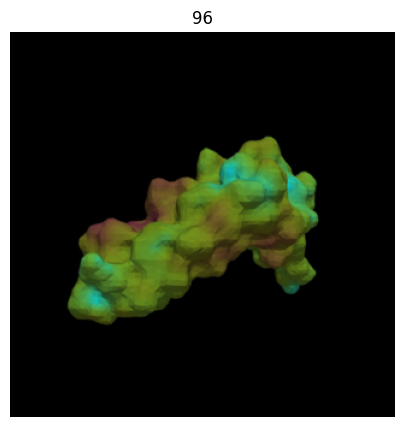

In [230]:
show_at(tls, 0)

In [231]:
items[:2]

(#2) [Path('/mnt/raid1/dataset/shrec-2025-protein-classification/v2-20250331/train-labeled-screenshots/96/0001-96-8ugd_8:R:3U_model1-0-0.jpg'),Path('/mnt/raid1/dataset/shrec-2025-protein-classification/v2-20250331/train-labeled-screenshots/96/0001-96-8ugd_8:R:3U_model1-0-45.jpg')]

In [232]:
splits = RandomSplitter(seed=42)(items)
splits

((#9718) [np.int64(7913),np.int64(356),np.int64(1436),np.int64(6005),np.int64(6333),np.int64(5283),np.int64(5734),np.int64(5277),np.int64(9191),np.int64(1292),np.int64(7017),np.int64(10995),np.int64(308),np.int64(476),np.int64(5650),np.int64(359),np.int64(3515),np.int64(5483),np.int64(6177),np.int64(3201)...],
 (#2429) [np.int64(10332),np.int64(10832),np.int64(4283),np.int64(4417),np.int64(6615),np.int64(8024),np.int64(9787),np.int64(5951),np.int64(10019),np.int64(6932),np.int64(4714),np.int64(5209),np.int64(8027),np.int64(4463),np.int64(2051),np.int64(5239),np.int64(1387),np.int64(132),np.int64(8028),np.int64(4341)...])

In [233]:
tls = TfmdLists(items, [Resize(env['img_sz']), ProteinsTfm(), FlipItem(p=0.5), ToTensor()], splits=splits)

Calling ProteinsTfm.setups()


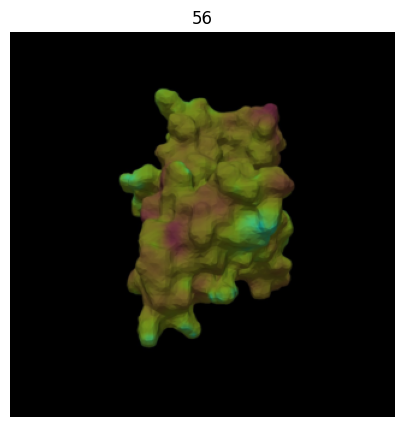

In [234]:
show_at(tls.train, 0)

In [235]:
dls = tls.dataloaders(bs=64)

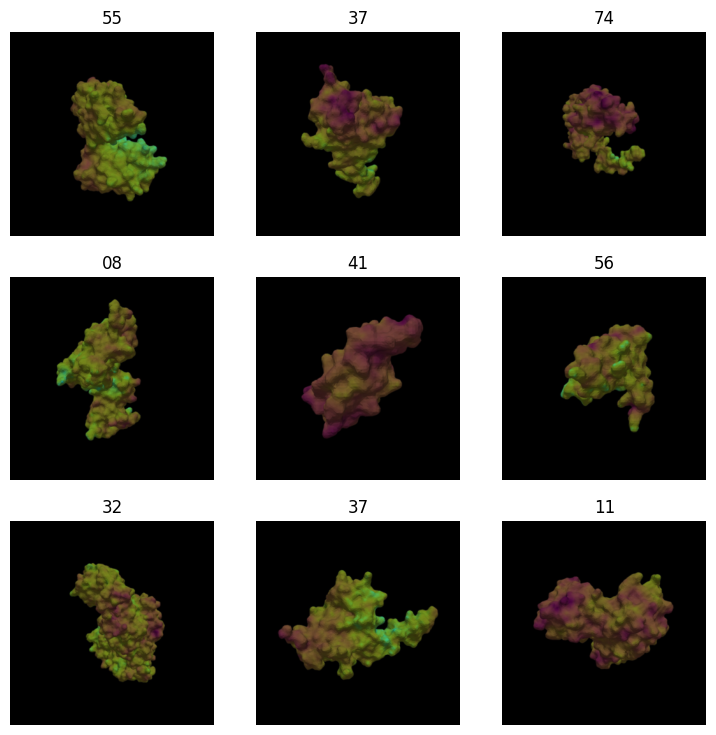

In [236]:
dls.show_batch()

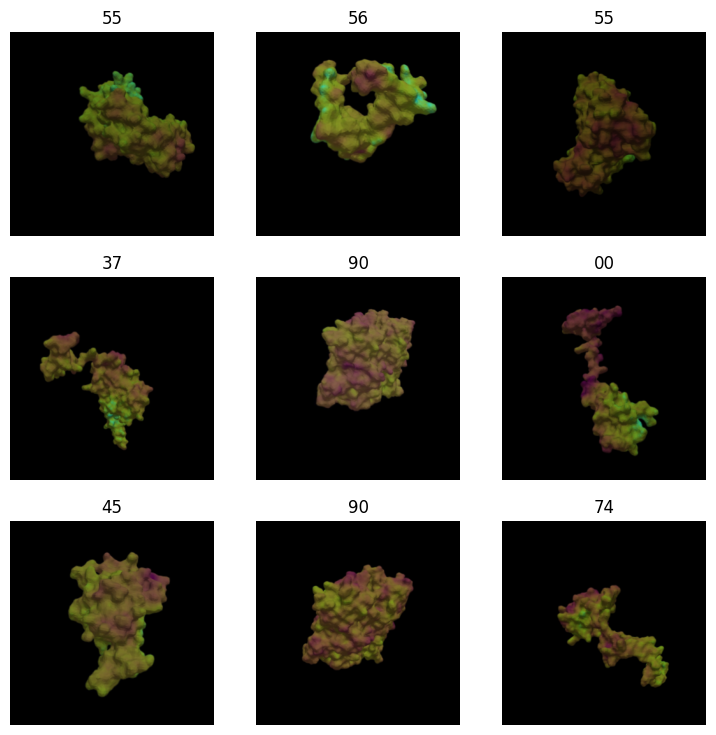

In [237]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms()])
dls.show_batch()

In [245]:
dsets = Datasets(items, tfms=Pipeline([Resize(env['img_sz']), ProteinsTfm(), FlipItem(p=0.5), ToTensor()]))

In [246]:
t = dsets[0]
type(t[0]),type(t[1])

AttributeError: 'ProteinsTfm' object has no attribute 'o2i'

In [178]:
t

(Path('/mnt/raid1/dataset/shrec-2025-protein-classification/v2-20250331/train-labeled-screenshots/96/0001-96-8ugd_8:R:3U_model1-0-0.jpg'),)

In [ ]:
def train(dls):
    '''
    dls = ImageDataLoaders.from_name_func(
        path, get_image_files(path), valid_pct=0.2,
        label_func=lambda x: x[0].isupper(), item_tfms=Resize(224))
    '''
    learn = vision_learner(dls, resnet50, metrics=[accuracy]).to_fp16()
    with learn.distrib_ctx(in_notebook=True, sync_bn=False):
        learn.fine_tune(10)

In [186]:
learn = vision_learner(dls, resnet50, metrics=[accuracy], loss_func=CrossEntropyLossFlat()).to_fp16()

In [188]:
#with learn.distrib_ctx(in_notebook=True, sync_bn=False):
learn.fine_tune(10)

/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,3.077258,2.227991,0.417867,00:29


epoch,train_loss,valid_loss,accuracy,time
0,1.940441,1.584024,0.532318,00:33
1,1.370194,1.024256,0.667764,00:33
2,0.929843,0.952726,0.696171,00:32
3,0.634731,0.537843,0.810622,00:33
4,0.468142,0.489364,0.831206,00:32
5,0.337562,0.344011,0.876081,00:33
6,0.238316,0.329707,0.875257,00:33
7,0.186776,0.282959,0.898724,00:32
8,0.154372,0.225936,0.920955,00:33
9,0.141627,0.239320,0.915603,00:32


In [250]:
one_batch = learn.dls.one_batch()

In [253]:
one_batch[0].shape

torch.Size([64, 3, 320, 320])

In [254]:
one_batch[1].shape

torch.Size([64])

In [255]:
one_batch[1][0]

tensor(7, device='cuda:0')

AttributeError: 'str' object has no attribute 'show'

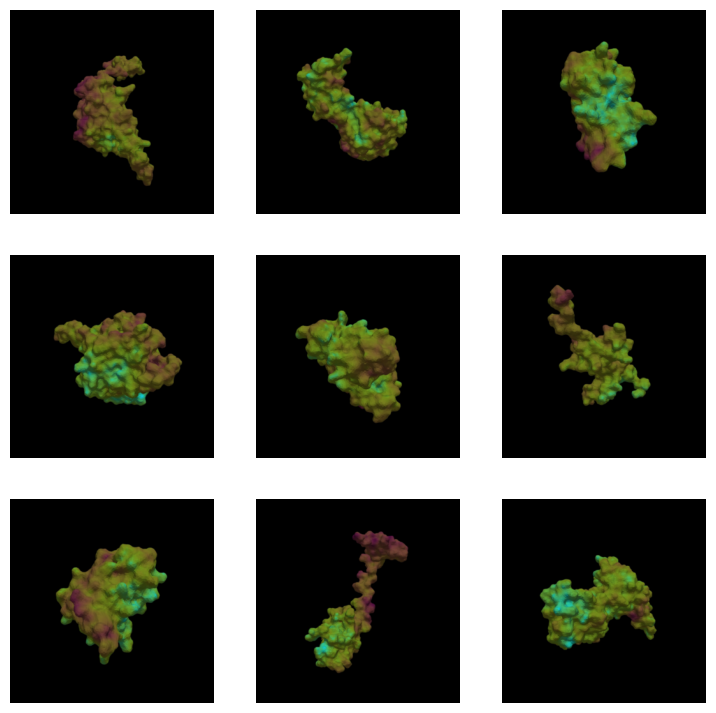

In [247]:
learn.show_results()

In [257]:
interp = ClassificationInterpretation.from_learner(learn)

/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


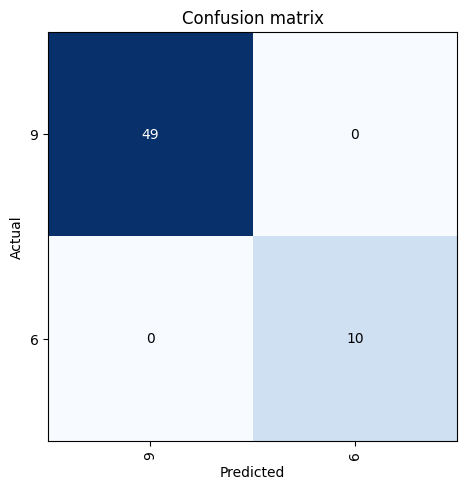

In [262]:
interp.plot_confusion_matrix()

In [266]:
interp.plot_top_losses(k=9)

/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/mnt/raid1/venvs/sam2/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Exception: plot_top_losses is not implemented for <class 'fastai.torch_core.TensorImage'>,<class 'torch.Tensor'>